In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Populating the interactive namespace from numpy and matplotlib


In [2]:
import json
import torch
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
from ssl_neuron.datasets import GraphDataset
from ssl_neuron.utils import plot_neuron, plot_tsne, neighbors_to_adjacency_torch, compute_eig_lapl_torch_batch
from ssl_neuron.graphdino import create_model

#### Load config

In [5]:
config = json.load(open('../configs/config.json'))

#### Load model + checkpoint

In [6]:
model = create_model(config)

In [7]:
state_dict = torch.load('../ckpts/ckpt.pt')

In [8]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
model.eval()
model.cuda();

#### Load dataset

In [10]:
dset = GraphDataset(config, mode='all')

430it [00:02, 193.47it/s]


In [11]:
feat, neigh = dset.__getsingleitem__(0)

In [12]:
feat.shape, len(neigh)

((1000, 8), 1000)

#### Plot neuron

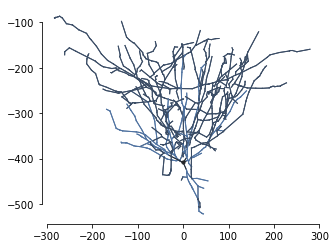

In [14]:
plot_neuron(neigh, feat)

#### Run inference

In [15]:
latents = np.zeros((dset.num_samples, config['model']['dim']))

for i in tqdm(range(dset.num_samples)):
    feat, neigh = dset.__getsingleitem__(i)
    adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
    lapl = compute_eig_lapl_torch_batch(adj, pos_enc_dim=config['model']['pos_dim']).float().cuda()
    feat = torch.from_numpy(feat).float().cuda()[None, ]
    
    latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()


100%|██████████| 430/430 [05:02<00:00,  1.42it/s]


<ErrorbarContainer object of 3 artists>

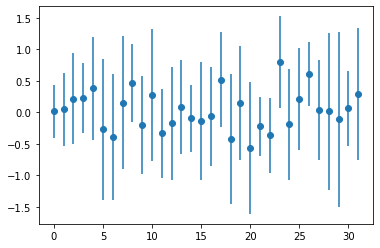

In [16]:
plt.scatter(np.arange(config['model']['dim']), latents.mean(axis=0))

plt.errorbar(np.arange(config['model']['dim']), latents.mean(axis=0), yerr = latents.std(axis=0), fmt='none')

In [17]:
colors = [list(sns.color_palette("mako", n_colors=10)[3])] + [list(sns.color_palette("mako", n_colors=10)[-2])]

In [18]:
z = TSNE(n_components=2, perplexity=30).fit_transform(latents)

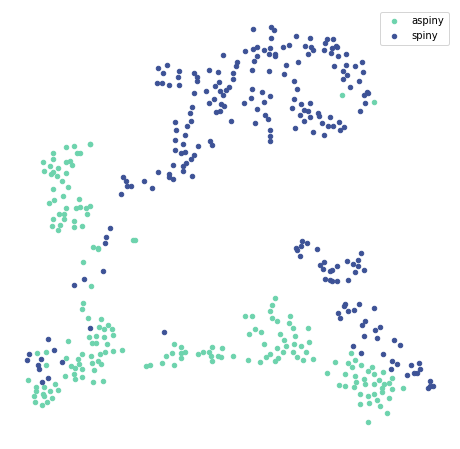

In [19]:
plot_tsne(z, np.concatenate([np.zeros(200, dtype=int), np.ones(230, dtype=int)]), targets=['aspiny', 'spiny'], colors=[colors[1], colors[0]])